# Step 1: Brief description of the problem and data

In this notebook, I will be training a model to predict whether a given tweet is about a real disaster (1) or not (0).

The training data provided in `train.csv` contains the following columns:
* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - this denotes whether a tweet is about a real disaster (1) or not (0)

Since the size of the data is not mentioned in the Kaggle data description, let's do a quick check to see how many rows of data are in the `train.csv` file.

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.src.optimizers import Adam
from keras_tuner import Hyperband
import re
import emoji
import string

In [96]:
file_name = "train.csv"
data = pd.read_csv(file_name)
num_rows = data.shape[0]
print(f"The number of rows in '{file_name}' is {num_rows}.")

The number of rows in 'train.csv' is 7613.


# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

## Step 2 Part 1: Overview
Let's take a look at some basic statistics of the data like mean, standard deviation, min, and max for numerical columns (e.g., id, target).

In [97]:
print("\nFirst 5 rows of the dataset:")
print(data.head())

print("\nSummary statistics for numerical columns:")
print(data.describe())

print("\nData types of each column:")
print(data.dtypes)

print("\nMissing values in each column:")
print(data.isnull().sum())

print("\nPercentage of missing values in each column:")
missing_percentage = (data.isnull().sum() / len(data)) * 100
print(missing_percentage)

duplicate_rows = data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)

text_duplicates = data['text'].duplicated().sum()
print("\nNumber of duplicate rows based on 'text' column:", text_duplicates)

print("\nNumber of unique values in each column:")
print(data.nunique())


First 5 rows of the dataset:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

Summary statistics for numerical columns:
                 id      target
count   7613.000000  7613.00000
mean    5441.934848     0.42966
std     3137.116090     0.49506
min        1.000000     0.00000
25%     2734.000000     0.00000
50%     5408.000000     0.00000
75%     8146.000000     1.00000
max    10873.000000     1.00000

Data types of each column:
id           int64
keyword     object
location    object
text        object


## Step 2 Part 2: `Target` Distribution
Is the distribution of the `target` column balanced?  If not, re-balancing may be needed.

Distribution of the target column:
target
0    4342
1    3271
Name: count, dtype: int64

Percentage of each target class:
target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


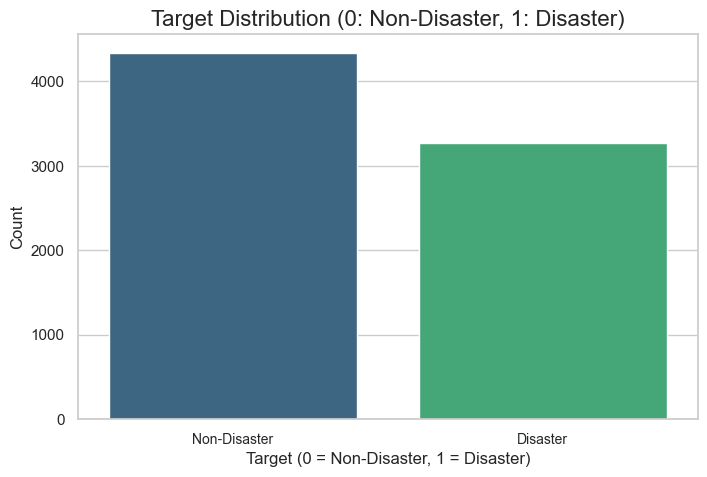

In [98]:
print("Distribution of the target column:")
print(data['target'].value_counts())

print("\nPercentage of each target class:")
target_percentage = (data['target'].value_counts(normalize=True)) * 100
print(target_percentage)

plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='target', hue='target', legend=False, palette='viridis')
plt.title('Target Distribution (0: Non-Disaster, 1: Disaster)', fontsize=16)
plt.xlabel('Target (0 = Non-Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'], fontsize=10)
plt.show()

## Step 2 Part 3: `Text` Analysis
Now let's look at text length, most common words, stopwords and special characters, the prevalence of stopwords (e.g., "the", "is"), and sentiment analysis.

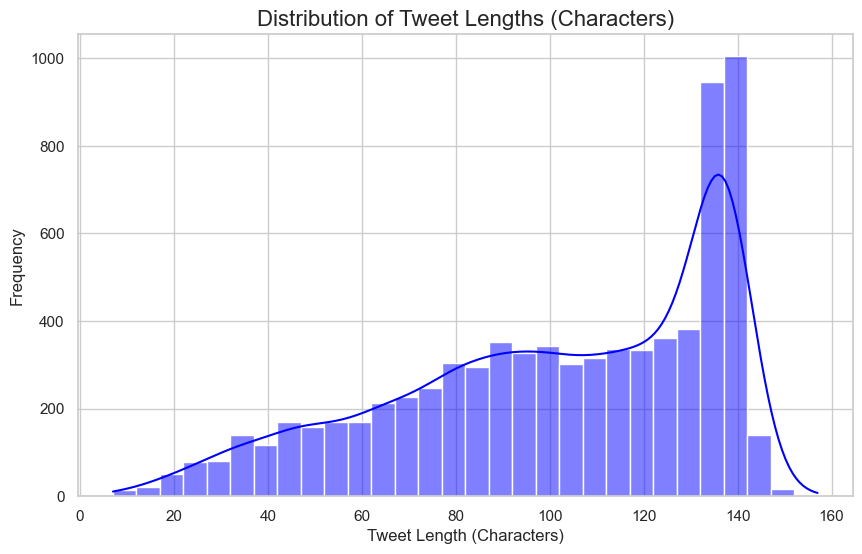

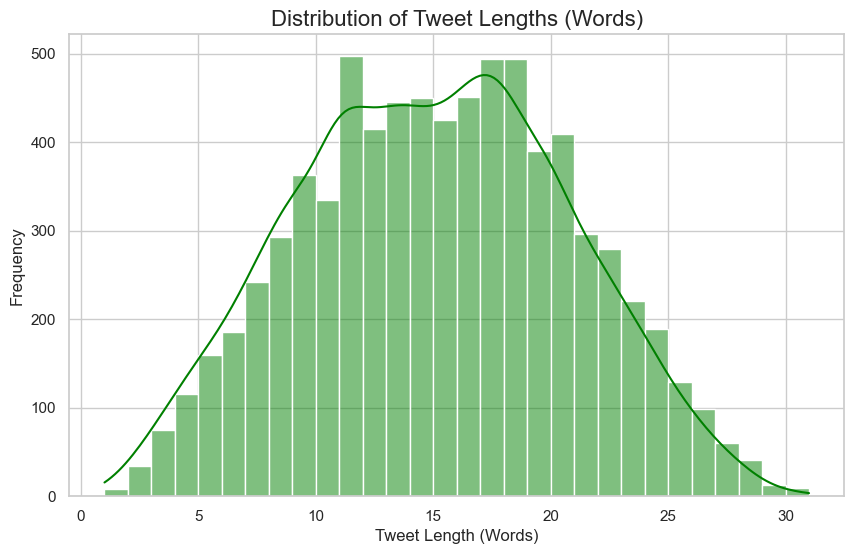

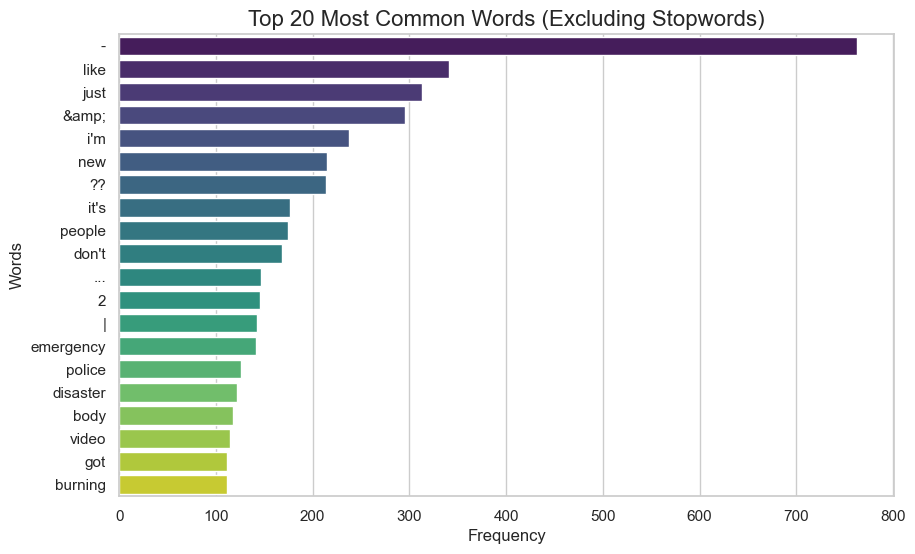

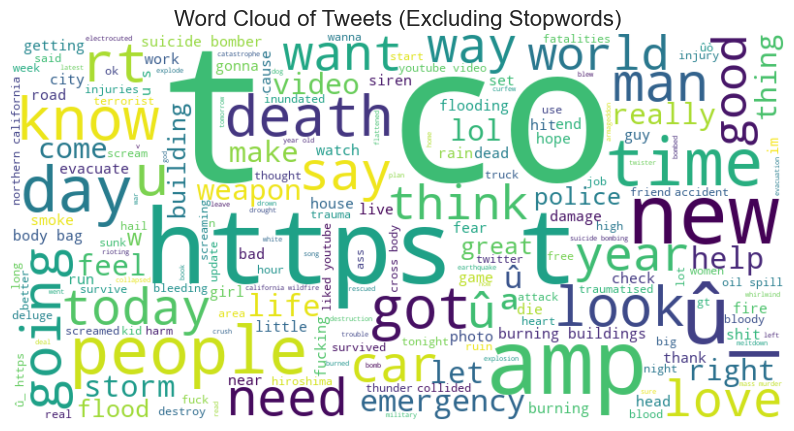

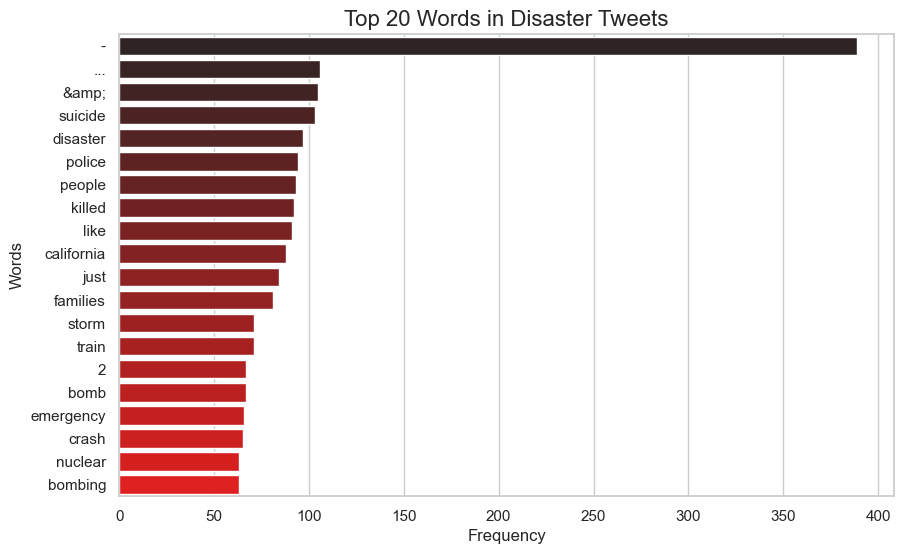

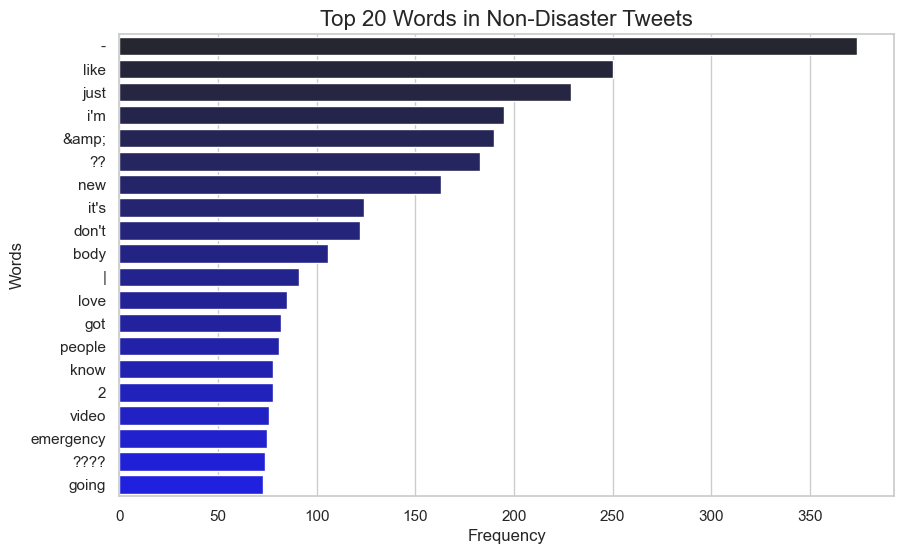

In [99]:
# Calculate tweet lengths (number of characters and words)
data['text_length'] = data['text'].apply(len)
data['word_count'] = data['text'].apply(lambda x: len(x.split()))

# Visualize tweet lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['text_length'], bins=30, kde=True, color='blue')
plt.title('Distribution of Tweet Lengths (Characters)', fontsize=16)
plt.xlabel('Tweet Length (Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['word_count'], bins=30, kde=True, color='green')
plt.title('Distribution of Tweet Lengths (Words)', fontsize=16)
plt.xlabel('Tweet Length (Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Tokenize text and count word frequencies
stop_words = ENGLISH_STOP_WORDS
all_words = [word.lower() for tweet in data['text'] for word in tweet.split() if word.lower() not in stop_words]

word_counts = Counter(all_words)
most_common_words = word_counts.most_common(20)

# Visualize most common words
words, counts = zip(*most_common_words)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(words), hue=list(words), palette='viridis')
plt.title('Top 20 Most Common Words (Excluding Stopwords)', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

# Word cloud for entire dataset
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweets (Excluding Stopwords)', fontsize=16)
plt.show()

# Compare most common words between target classes
disaster_words = [word.lower() for tweet in data[data['target'] == 1]['text'] for word in tweet.split() if word.lower() not in stop_words]
non_disaster_words = [word.lower() for tweet in data[data['target'] == 0]['text'] for word in tweet.split() if word.lower() not in stop_words]

disaster_counts = Counter(disaster_words).most_common(20)
non_disaster_counts = Counter(non_disaster_words).most_common(20)

# Plot disaster vs. non-disaster word frequencies
disaster_words, disaster_freq = zip(*disaster_counts)
non_disaster_words, non_disaster_freq = zip(*non_disaster_counts)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(disaster_freq), y=list(disaster_words), hue=list(disaster_words), palette='dark:red')
plt.title('Top 20 Words in Disaster Tweets', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(non_disaster_freq), y=list(non_disaster_words), hue=list(non_disaster_words), palette='dark:blue')
plt.title('Top 20 Words in Non-Disaster Tweets', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
plt.show()

Continuing with the `text` analysis, lets take a look at hashtags, mentions, and emojis.

In [100]:
# Define helper functions to count hashtags, mentions, and emojis
def count_hashtags(text):
    return len(re.findall(r"#\w+", text))

def count_mentions(text):
    return len(re.findall(r"@\w+", text))

def count_emojis(text):
    return len([char for char in text if char in emoji.EMOJI_DATA])

# Apply the functions to the 'text' column, and create a new column for counts of hashtags, mentions, and emojis
data['hashtag_count'] = data['text'].apply(count_hashtags)
data['mention_count'] = data['text'].apply(count_mentions)
data['emoji_count'] = data['text'].apply(count_emojis)

# Display the counts
print("Hashtag Counts:\n", data['hashtag_count'].value_counts())
print("Mention Counts:\n", data['mention_count'].value_counts())
print("Emoji Counts:\n", data['emoji_count'].value_counts())

Hashtag Counts:
 hashtag_count
0     5870
1      964
2      407
3      202
4       71
5       39
6       27
10      10
8        8
7        7
13       4
11       2
9        2
Name: count, dtype: int64
Mention Counts:
 mention_count
0    5604
1    1531
2     338
3      86
4      30
5      17
6       5
8       1
7       1
Name: count, dtype: int64
Emoji Counts:
 emoji_count
0    7603
1      10
Name: count, dtype: int64


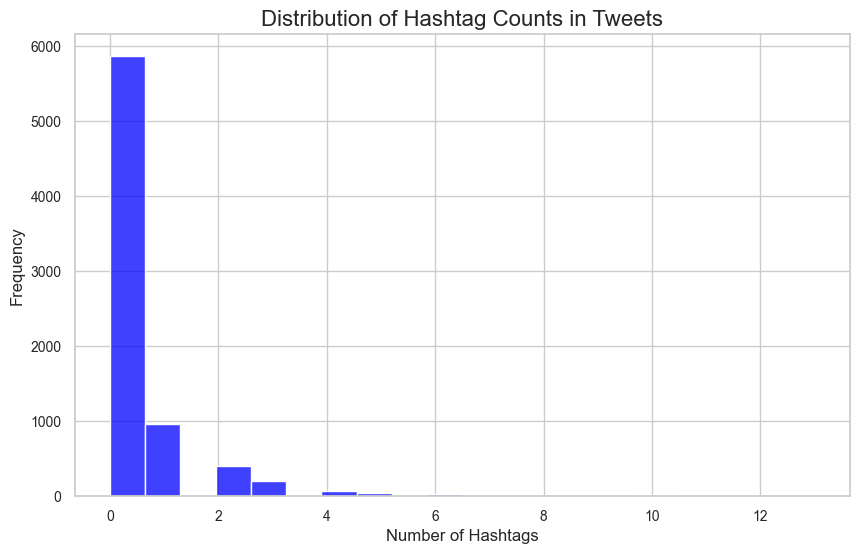

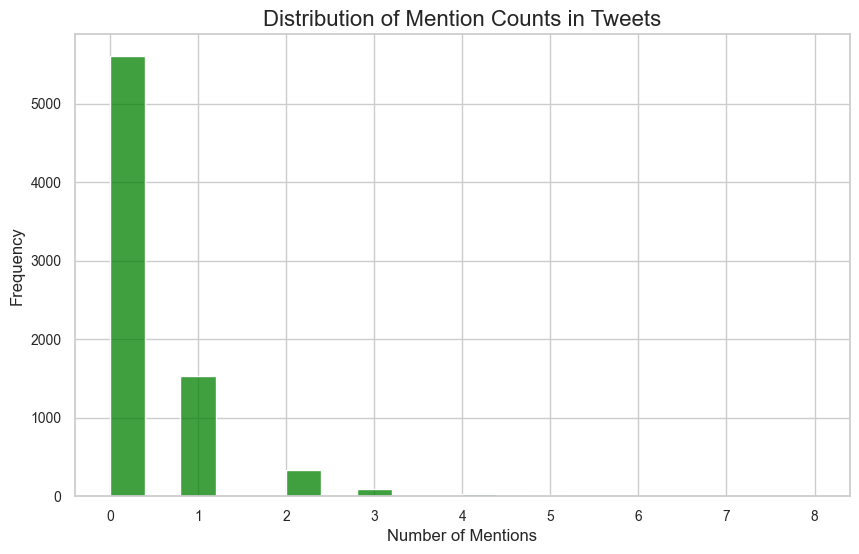

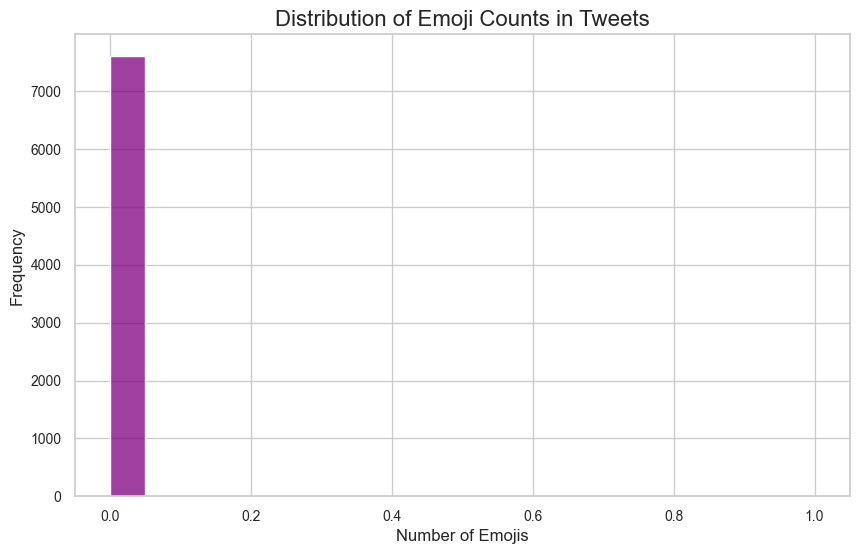

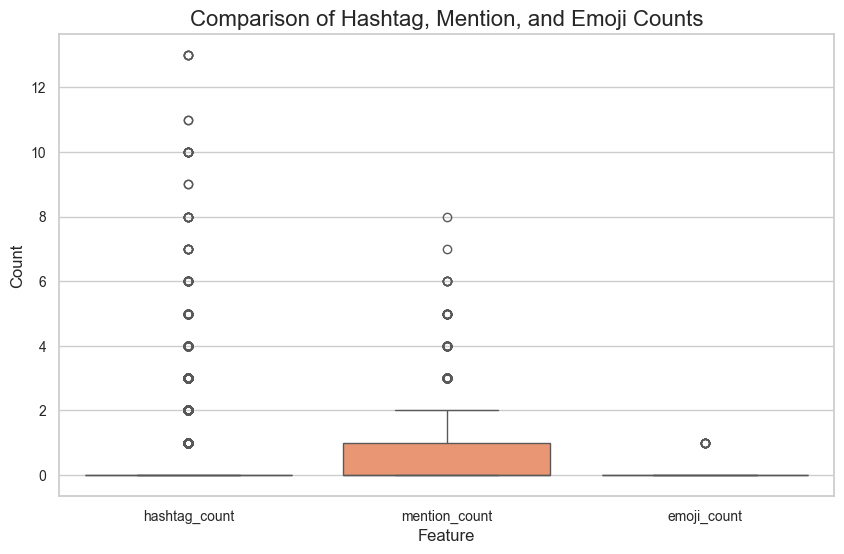

In [101]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(data['hashtag_count'], bins=20, kde=False, color='blue')
plt.title('Distribution of Hashtag Counts in Tweets', fontsize=16)
plt.xlabel('Number of Hashtags', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['mention_count'], bins=20, kde=False, color='green')
plt.title('Distribution of Mention Counts in Tweets', fontsize=16)
plt.xlabel('Number of Mentions', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data['emoji_count'], bins=20, kde=False, color='purple')
plt.title('Distribution of Emoji Counts in Tweets', fontsize=16)
plt.xlabel('Number of Emojis', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Compare counts across the three categories using box plots
plt.figure(figsize=(10, 6))
df_melted = data.melt(value_vars=['hashtag_count', 'mention_count', 'emoji_count'],
                    var_name='Feature', value_name='Count')
sns.boxplot(x='Feature', y='Count', data=df_melted, hue='Feature', legend=False, palette='Set2')
plt.title('Comparison of Hashtag, Mention, and Emoji Counts', fontsize=16)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

## Step 2 Part 4: `Keyword` Analysis
Let's look at the most frequently occurring keywords, examine if specific keywords are associated with real disasters (target = 1), and analyze the correlation between keywords and the target class.


Keyword distribution (with NaN):
keyword
NaN            61
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
evacuate       40
fear           40
Name: count, dtype: int64

Keyword distribution (excluding NaN):
keyword
fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
Name: count, dtype: int64

Percentage of missing keywords: 0.80%


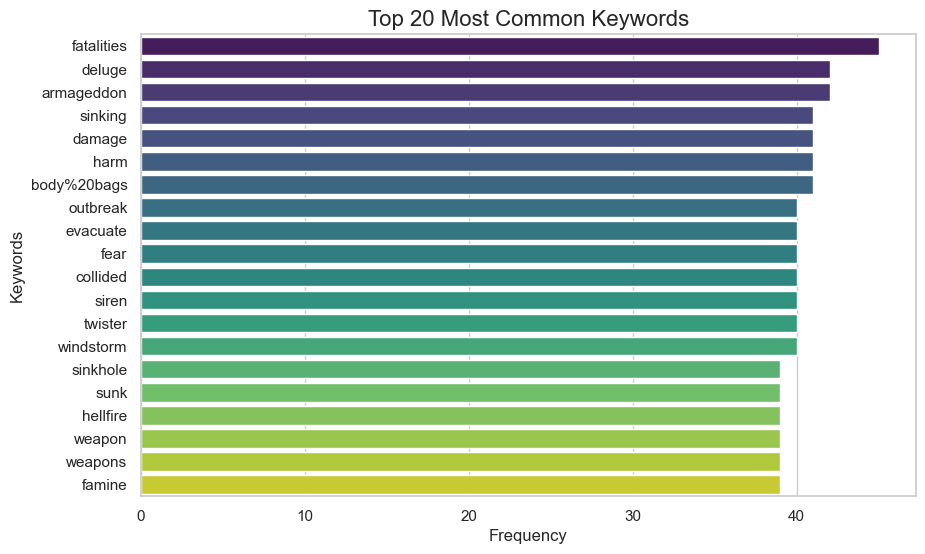

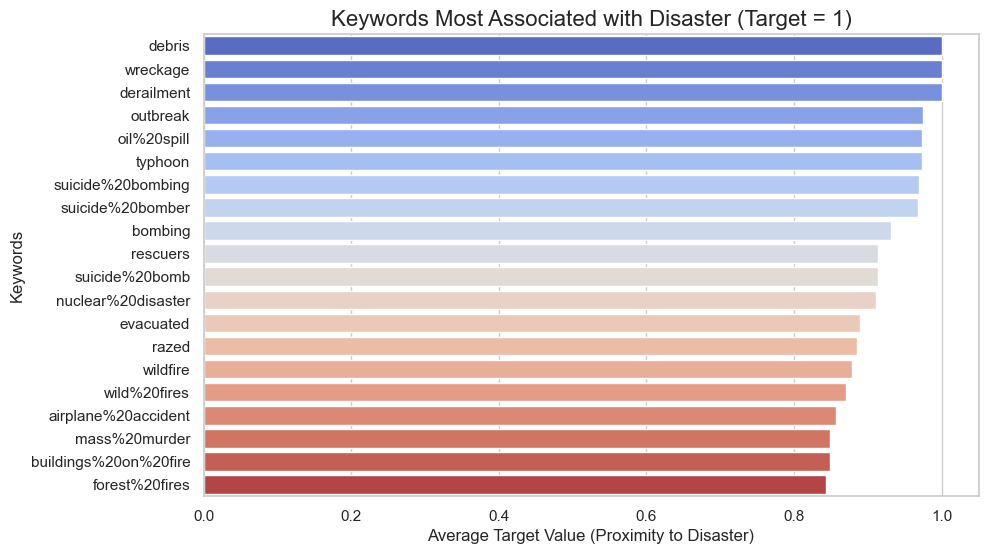

In [102]:
print("Keyword distribution (with NaN):")
print(data['keyword'].value_counts(dropna=False).head(10))

print("\nKeyword distribution (excluding NaN):")
print(data['keyword'].dropna().value_counts().head(10))

missing_keywords = data['keyword'].isnull().sum()
total_rows = len(data)
print(f"\nPercentage of missing keywords: {missing_keywords / total_rows * 100:.2f}%")

# Visualize the most common keywords
top_keywords = data['keyword'].dropna().value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, hue=top_keywords.index, palette="viridis")
plt.title('Top 20 Most Common Keywords', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Keywords', fontsize=12)
plt.show()

# Group by keyword and calculate the mean target (higher mean implies more likely to be disaster-related)
keyword_target_relation = data.groupby('keyword')['target'].mean().sort_values(ascending=False).dropna().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=keyword_target_relation.values, y=keyword_target_relation.index, hue=keyword_target_relation.index, palette="coolwarm")
plt.title('Keywords Most Associated with Disaster (Target = 1)', fontsize=16)
plt.xlabel('Average Target Value (Proximity to Disaster)', fontsize=12)
plt.ylabel('Keywords', fontsize=12)
plt.show()

## Step 2 Part 5: Top Locations
Let's take a look at the most common location values, the location-target relationship, and missing locations.

Location distribution (with NaN):
location
NaN                2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64

Location distribution (excluding NaN):
location
USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Name: count, dtype: int64

Percentage of missing locations: 33.27%


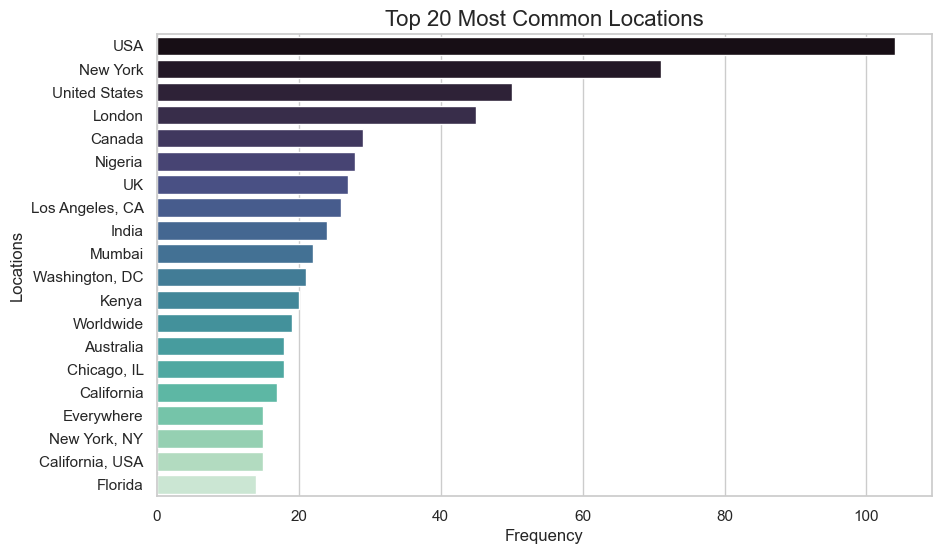

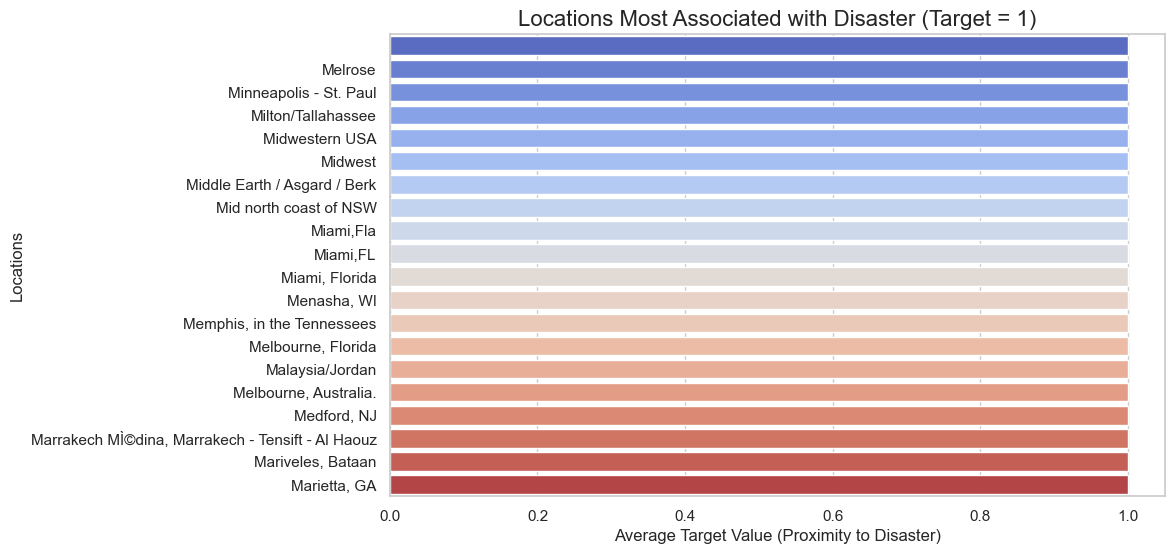

In [103]:
print("Location distribution (with NaN):")
print(data['location'].value_counts(dropna=False).head(10))

print("\nLocation distribution (excluding NaN):")
print(data['location'].dropna().value_counts().head(10))

missing_locations = data['location'].isnull().sum()
total_rows = len(data)
print(f"\nPercentage of missing locations: {missing_locations / total_rows * 100:.2f}%")

# Visualize most common locations
top_locations = data['location'].dropna().value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_locations.values, y=top_locations.index, hue=top_locations.index, legend=False, palette="mako")
plt.title('Top 20 Most Common Locations', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Locations', fontsize=12)
plt.show()

# Group by location and calculate the mean target (higher mean implies more likely to be disaster-related)
location_target_relation = data.groupby('location')['target'].mean().sort_values(ascending=False).dropna().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=location_target_relation.values, y=location_target_relation.index, hue=location_target_relation.index, legend=False, palette="coolwarm")
plt.title('Locations Most Associated with Disaster (Target = 1)', fontsize=16)
plt.xlabel('Average Target Value (Proximity to Disaster)', fontsize=12)
plt.ylabel('Locations', fontsize=12)
plt.show()

## Step 2 Part 6: Correlations
Next I'll compare tweet lengths, word counts, and vocabulary richness between the two classes.  Then I'll look for keyword-location interaction, such as how often specific keywords appear in tweets from particular locations.


Correlation matrix:
               target  text_length  word_count
target       1.000000     0.181817    0.039966
text_length  0.181817     1.000000    0.837386
word_count   0.039966     0.837386    1.000000


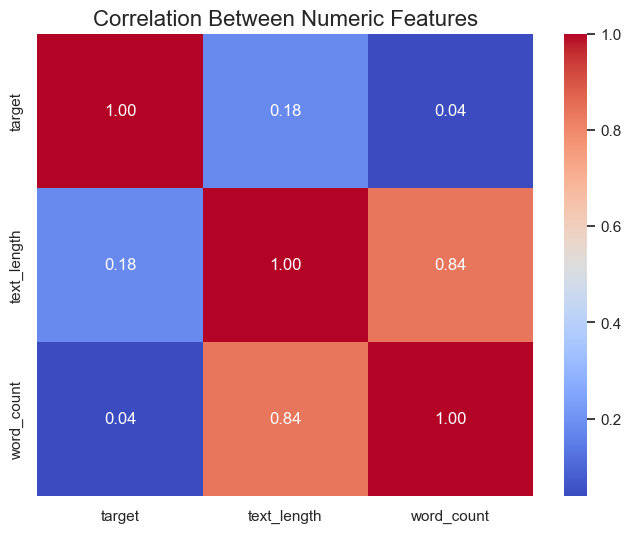

In [104]:
# Select only numeric features for correlation
numeric_features = data[['target', 'text_length', 'word_count']]
correlation_matrix = numeric_features.corr()
print("Correlation matrix:")
print(correlation_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Between Numeric Features', fontsize=16)
plt.show()

## Step 2 Conclusion
We learned a lot through the EDA above.  Here's a summary.
1. **Overview**: There are 0 duplicate rows, but there are 110 duplicate rows based on the `text` column.  If 2 rows have the same `text` but only one row has `location`, we should keep the row that contains more information and delete the other.  There are some NaN values in the `keyword` and `location` columns that may cause issues in certain tools that we use later (i.e. TF-IDF as a text vectorizer or Tokenizer as a text preprocessing library).
2. **`Target` Distribution**: The training data contains 57% non-disaster (target=0) and 43% disaster.
3. **`Text` Analysis**: Tweets with close to 140 characters were the most common, and the most common number of words in a tweet was 10-20 words.  When comparing the most common words in disaster vs. non-disaster tweets, some words were common in both types such as "like", "&amp", "just", "-", and "2".  Other words were only popular in either disaster or non-disaster tweets.  For example, words such as "i'm", "??", "new", and "it's" were popular in non-disaster tweets, while words such as "suicide", "disaster", "police", and "people" were popular in disaster tweets.  The text contains a significant number of hashtags and mentions, along with a few emojis.
4. **`Keyword` Analysis**: We learned in step 2 part 1 that there are 221 unique keywords, and that a majority of entries in the training data (99.2%) have keywords.  By viewing the top 20 keywords in one visualization and the keywords most associated with disaster in another visualization, we saw many keywords that were associated with disaster but not among the most popular keywords such as "debris", "wreckage", and "derailment" that may be helpful in identifying disaster tweets.
5. **Top Locations**: We looked at the most common locations and then looked at the locations most commonly associated with disasters.  General / vague locations such as "USA" and "United States" were common, while specific locations such as "Melrose" and "Minneapolis - St. Paul" were commonly associated with disasters.
6. **Correlations**: Both the text length and the word count were poorly correlated with the target.

Based on this EDA, the following data cleanup will be performed:
* Clean up the 110 duplicate rows based on the `text` column by deleting the row with less information.  For example, if 2 rows have the same `text` but only one row has `location`, should keep the row that contains more information and delete the other.
* Fill in `NaN` values in the `keyword` and `location` fields with "Unknown".  I chose "Unknown" rather than leaving the `NaN` value or replacing with a blank value "" so that this information can be used to signal "missingness" to the model explicitly.  Another alternative would be to delete all training entries with `NaN` values, but that would cause us to lose a lot of useful training data, which is undesirable.
* Remove all hashtags, mentions, and emojis.

In [105]:
def replace_nan_values_with_unknown(data):
    data['keyword'] = data['keyword'].fillna("Unknown")
    data['location'] = data['location'].fillna("Unknown")

replace_nan_values_with_unknown(data)

In [106]:
def remove_duplicates(data):
    # Remove duplicates that contain the least information (i.e. if the same text appears twice and one instance contains a location, keep the entry with the location)
    def info_score(row):
        score = 0
        if pd.notnull(row['location']) and row['location'].strip() != '':
            score += 1
        if pd.notnull(row['keyword']) and row['keyword'].strip() != '':
            score += 1
        return score

    # Add a new column 'info_score' to rank rows based on the amount of information
    data['info_score'] = data.apply(info_score, axis=1)
    data = data.sort_values(by=['text', 'info_score'], ascending=[True, False])

    # Remove duplicates based on 'text', keeping the row with the highest 'info_score'
    data = data.drop_duplicates(subset='text', keep='first')
    data = data.drop(columns=['info_score'])

remove_duplicates(data)

# Print duplicate row info to confirm that all duplicates have been removed
duplicate_rows = data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicate_rows)

text_duplicates = data['text'].duplicated().sum()
print("\nNumber of duplicate rows based on 'text' column:", text_duplicates)


Number of duplicate rows: 0

Number of duplicate rows based on 'text' column: 110


In [107]:
def remove_urls_mentions_hashtags_emojis(data):
    def clean_text(text):
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
        # Remove mentions (e.g., @username)
        text = re.sub(r"@\w+", "", text)
        # Remove hashtags (but keep the text after #, e.g., #disaster -> disaster)
        text = re.sub(r"#", "", text)
        # Remove emojis
        text = emoji.replace_emoji(text, replace="")
        # Remove extra whitespaces
        text = re.sub(r"\s+", " ", text).strip()
        return text

    # Apply the cleaning function to the 'text' column
    data['text'] = data['text'].apply(clean_text)

remove_urls_mentions_hashtags_emojis(data)

In [108]:
def lowercase_text_and_remove_punctuation(data):
    def lowercase_text_and_remove_punctuation_helper(text):
        text = text.lower()
        text = text.translate(str.maketrans("", "", string.punctuation))
        return text

    data['text'] = data['text'].apply(lowercase_text_and_remove_punctuation_helper)

lowercase_text_and_remove_punctuation(data)

# Step 3: Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem.

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.).

In [112]:
def open_file_and_clean_data(input_file):
    df = pd.read_csv(input_file)

    replace_nan_values_with_unknown(df)
    remove_duplicates(df)
    remove_urls_mentions_hashtags_emojis(df)
    lowercase_text_and_remove_punctuation(df)

    # Combine all features into a single text representation
    df['text'] = df['keyword'] + " " + df['location'] + " " + df['text']
    return df

In [113]:
data = open_file_and_clean_data("train.csv")

X = data['text']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

tfidf = TfidfVectorizer(max_features=5000)

def text_to_tfidf(x_train, x_test):
    x_train_tfidf = tfidf.fit_transform(x_train).toarray()
    x_test_tfidf = tfidf.transform(x_test).toarray()
    return x_train_tfidf, x_test_tfidf

X_train_rep, X_test_rep = text_to_tfidf(X_train, X_test)
embedding_matrix = None
vocab_size = None
max_length = None
embedding_dim = None

model = Sequential()

# Add dense layers for TF-IDF representation
model.add(Dense(128, activation='relu', input_dim=X_train_rep.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_rep, y_train, epochs=10, batch_size=64, validation_data=(X_test_rep, y_test))
loss, accuracy = model.evaluate(X_test_rep, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10


/Users/asnyder/PycharmProjects/deep-learning-week4/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5690 - loss: 0.6672 - val_accuracy: 0.7991 - val_loss: 0.4570
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8308 - loss: 0.3967 - val_accuracy: 0.8148 - val_loss: 0.4365
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8761 - loss: 0.3021 - val_accuracy: 0.8129 - val_loss: 0.4716
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9143 - loss: 0.2225 - val_accuracy: 0.7984 - val_loss: 0.5273
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9380 - loss: 0.1667 - val_accuracy: 0.7886 - val_loss: 0.5896
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9595 - loss: 0.1212 - val_accuracy: 0.7866 - val_loss: 0.6662
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9644 - loss: 0.1019 - val_accuracy: 0.7794 - val_loss: 0.7398
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9777 - loss: 0.0713 - val_accuracy: 0.7577 - val_loss: 0.8320
Epo

In [114]:
def test_model(model, output_file_name='submission.csv'):
    test_df = open_file_and_clean_data("test.csv")

    X_test_final = tfidf.transform(test_df['text']).toarray()
    predictions = model.predict(X_test_final)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    submission = pd.DataFrame({'id': test_df['id'], 'target': predicted_labels})
    submission.to_csv(output_file_name, index=False)

    print("Submission file '", output_file_name, "' has been created.")

test_model(model)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
Submission file ' submission.csv ' has been created.


# Step 4: Results and Analysis

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

Now I'll build a model using hyperparameter tuning.  The following hyperparameters will be tuned:
1. Number of units in the dense layers
2. Dropout rate
3. Learning rate

I will use early stopping when performing the search to prevent overfitting.



In [118]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=32),
                    activation='relu', input_dim=X_train_rep.shape[1]))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.7, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=128, step=16),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_tuning',
    project_name='tweet_disaster_classification'
)

# Define early stopping to prevent overfitting during search
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train_rep, y_train, epochs=20, validation_data=(X_test_rep, y_test), callbacks=[early_stopping])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units_1')}.
The optimal dropout rate is {best_hps.get('dropout_1')}.
The optimal number of units in the second dense layer is {best_hps.get('units_2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

# Train the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_rep, y_train, epochs=20, batch_size=64, validation_data=(X_test_rep, y_test))

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test_rep, y_test)
print(f"Test Accuracy: {accuracy}")

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.8122127652168274

Best val_accuracy So Far: 0.8233749270439148
Total elapsed time: 00h 01m 44s

The optimal number of units in the first dense layer is 128.
The optimal dropout rate is 0.5.
The optimal number of units in the second dense layer is 64.
The optimal learning rate is 0.001.

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5946 - loss: 0.6635 - val_accuracy: 0.8050 - val_loss: 0.4659
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8270 - loss: 0.4058 - val_accuracy: 0.8155 - val_loss: 0.4429
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8913 - loss: 0.2764 - val_accuracy: 0.7938 - val_loss: 0.4789
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9146 - loss: 0.2217 - val_accuracy: 0.7905 - val_loss: 0.5273
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9422 - loss: 0.1626 - val_accuracy: 0.7833 - val_loss: 0.6000
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━

In [119]:
test_model(best_model, "best_submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
Submission file ' best_submission.csv ' has been created.


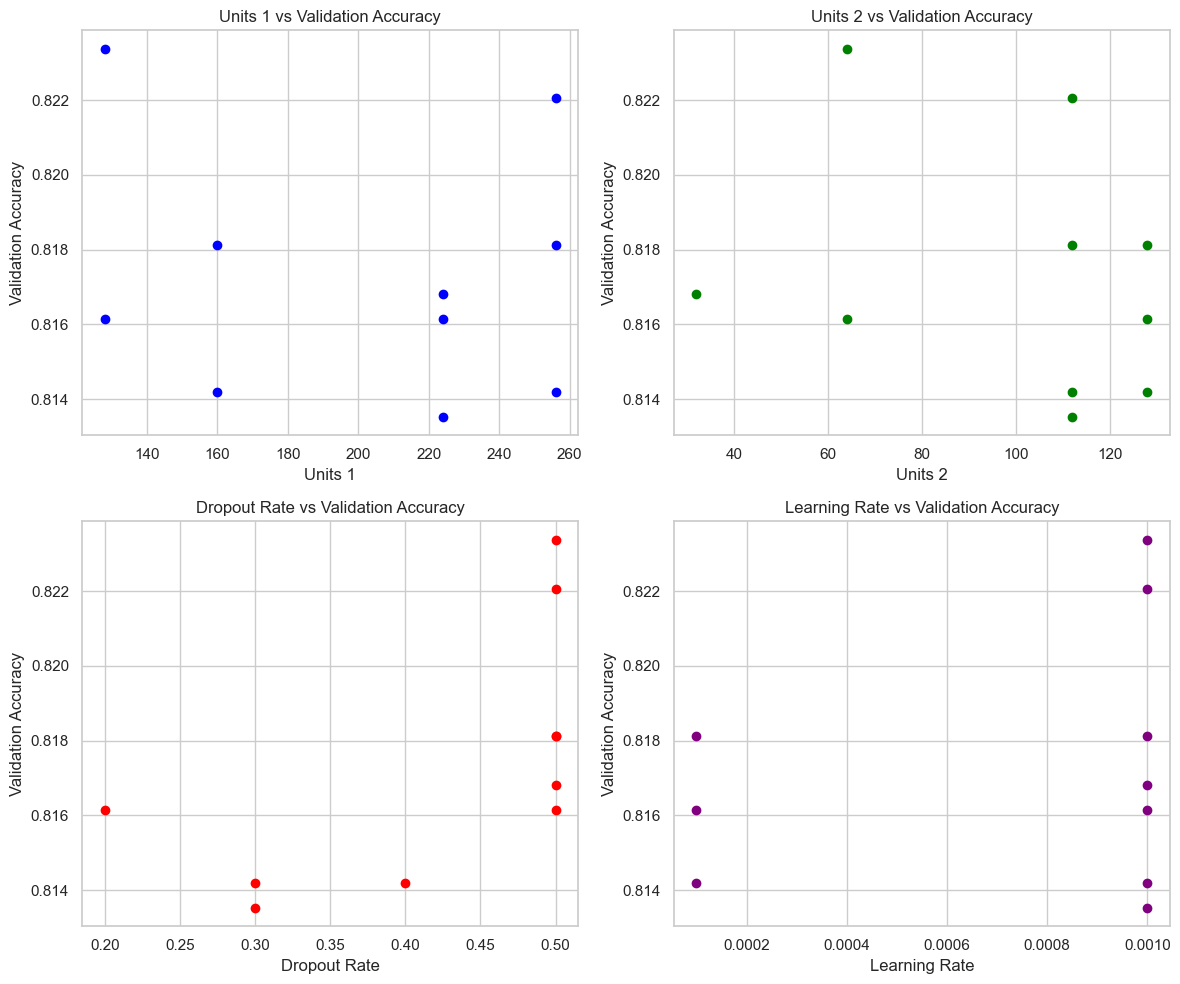

In [120]:
# Plot out the accuracy vs. the 4 hyperparameters that have been tuned to help see
# which hyperparameters have the largest impact on accuracy.
tuner_results = tuner.oracle.get_best_trials(num_trials=10)
units_1_list = []
units_2_list = []
dropout_1_list = []
learning_rate_list = []
val_accuracy_list = []

for trial in tuner_results:
    hp = trial.hyperparameters
    units_1_list.append(hp.get('units_1'))
    units_2_list.append(hp.get('units_2'))
    dropout_1_list.append(hp.get('dropout_1'))
    learning_rate_list.append(hp.get('learning_rate'))
    val_accuracy_list.append(trial.score)

results_df = pd.DataFrame({
    'units_1': units_1_list,
    'units_2': units_2_list,
    'dropout_1': dropout_1_list,
    'learning_rate': learning_rate_list,
    'val_accuracy': val_accuracy_list
})

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].scatter(results_df['units_1'], results_df['val_accuracy'], c='blue')
axs[0, 0].set_title('Units in Dense Layer 1 vs Validation Accuracy')
axs[0, 0].set_xlabel('Units 1')
axs[0, 0].set_ylabel('Validation Accuracy')

axs[0, 1].scatter(results_df['units_2'], results_df['val_accuracy'], c='green')
axs[0, 1].set_title('Units in Dense Layer 2 vs Validation Accuracy')
axs[0, 1].set_xlabel('Units 2')
axs[0, 1].set_ylabel('Validation Accuracy')

axs[1, 0].scatter(results_df['dropout_1'], results_df['val_accuracy'], c='red')
axs[1, 0].set_title('Dropout Rate vs Validation Accuracy')
axs[1, 0].set_xlabel('Dropout Rate')
axs[1, 0].set_ylabel('Validation Accuracy')

axs[1, 1].scatter(results_df['learning_rate'], results_df['val_accuracy'], c='purple')
axs[1, 1].set_title('Learning Rate vs Validation Accuracy')
axs[1, 1].set_xlabel('Learning Rate')
axs[1, 1].set_ylabel('Validation Accuracy')

plt.tight_layout()
plt.show()


# Step 5: Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?